In [68]:
import pandas as pd

def load_dataframe(crypto):
    cryptoDf = pd.read_csv(crypto+'.csv')
    cryptoDf = cryptoDf[:-1]
    cryptoDf['Date'] = pd.to_datetime(cryptoDf['Date'])
    cryptoDf.set_index("Date", drop=True, inplace=True)
    cryptoDf = cryptoDf.astype('float32')
    cryptoDf = cryptoDf.interpolate(method='linear')
    return cryptoDf

crypto = 'XRP' #@param {type: "string"}
cryptoDf = load_dataframe(crypto)
cryptoDf.tail()

,Open,High,Low,Close,Volume,Quote Volume,Weighted Price
Date,,,,,,,
2021-04-13,1.530637,1.855072,1.457779,1.758551,44097412.0,1.625874e+12,1.688807
2021-04-14,1.794505,1.935710,1.552621,1.846428,60061056.0,2.124620e+12,1.789440
2021-04-15,1.834000,1.874307,1.672769,1.750865,13039907.0,4.674369e+11,1.756533
2021-04-16,1.713180,1.755625,1.449283,1.548937,18626444.0,7.131886e+11,1.606145
2021-04-17,1.542780,1.714131,1.532988,1.572154,7639965.5,2.893678e+11,1.615604


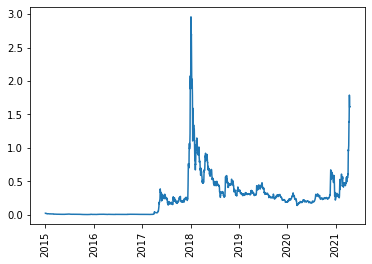

In [69]:
import matplotlib.pyplot as plt
from datetime import datetime

plt.plot(list(cryptoDf.index.values), list(cryptoDf['Weighted Price'].values))
plt.xticks(rotation='vertical')
plt.show()


In [70]:

lookback = 30 #@param {type: "number"}
train = 0.9 #@param {type: "number"}


In [71]:
from sklearn import preprocessing
from numpy import array
from numpy import hstack

ohlcv = cryptoDf[['Open', 'High', 'Close', 'Weighted Price', 'Volume', 'Low']]
ohlcv.index = cryptoDf.index

low = cryptoDf[['Low']]
low.index = cryptoDf.index

ohlcvNormalizer = preprocessing.MinMaxScaler()
ohlcv = pd.DataFrame(data=ohlcvNormalizer.fit_transform(ohlcv), columns=ohlcv.columns, index=ohlcv.index)

lowNormalizer = preprocessing.MinMaxScaler()
lowNormalizer.fit(low)

# split a multivariate sequence into samples
def split_sequences(sequences, lookback):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + lookback
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

dataset = hstack((array(ohlcv[label].values).reshape(len(ohlcv[label].values), 1) for label in ohlcv.columns))
X, y = split_sequences(dataset, lookback)
print(X.shape)
print(y.shape)


(2270, 30, 5)
(2270,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [72]:
trainSize = int(X.shape[0] * train)

X_train = X[:trainSize]
y_train = y[:trainSize]

X_test = X[trainSize-50:]
y_test = y[trainSize-50:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2043, 30, 5)
(2043,)
(277, 30, 5)
(277,)


In [73]:
#Market Indicators
import numpy as np

emas = []
for input in X:
    sma = np.mean(input[:,2])
    emas.append(sma)
k = 2/(lookback+1)
for i in range(len(emas)-1):
    emas[i+1] = y[i+1]*k + emas[i]*(1-k)
emas = [np.array([ema]) for ema in emas]
emas = np.array(emas)

emas_train = emas[:trainSize]
emas_test = emas[trainSize-50:]

print(emas_train.shape)
print(emas_test.shape)

(2043, 1)
(277, 1)


Epoch 1/30
115/115 [==============================] - 6s 34ms/step - loss: 0.0287 - val_loss: 7.1132e-05
Epoch 2/30
115/115 [==============================] - 3s 28ms/step - loss: 5.3734e-04 - val_loss: 8.9099e-05
Epoch 3/30
115/115 [==============================] - 3s 28ms/step - loss: 3.8219e-04 - val_loss: 6.3906e-05
Epoch 4/30
115/115 [==============================] - 3s 28ms/step - loss: 3.5413e-04 - val_loss: 3.8525e-05
Epoch 5/30
115/115 [==============================] - 3s 28ms/step - loss: 3.4764e-04 - val_loss: 3.5763e-05
Epoch 6/30
115/115 [==============================] - 3s 28ms/step - loss: 2.9572e-04 - val_loss: 4.3510e-05
Epoch 7/30
115/115 [==============================] - 3s 28ms/step - loss: 1.8962e-04 - val_loss: 2.7304e-05
Epoch 8/30
115/115 [==============================] - 3s 28ms/step - loss: 2.8805e-04 - val_loss: 2.5854e-05
Epoch 9/30
115/115 [==============================] - 3s 28ms/step - loss: 2.5526e-04 - val_loss: 1.9283e-05
Epoch 10/30
115/115 [==

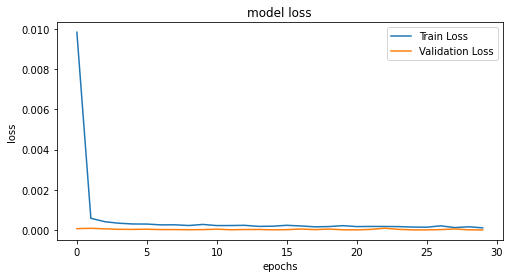

In [74]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
from tensorflow.random import set_seed
set_seed(4)

lstm_input = Input(shape=(lookback, X.shape[2]), name='lstm_input')
marketIndicators_input = Input(shape=(emas.shape[1],), name="marketIndicators_input")

lstm = LSTM(128, name='lstm_0')(lstm_input)
lstm_dropout = Dropout(0.2, name='lstm_dropout_0')(lstm)
#lstm = Model(inputs=lstm_input, outputs=x)

marketIndicators_dense = Dense(64, name='marketIndicators_dense_0')(marketIndicators_input)
marketIndicators_relu_activation = Activation("relu", name='marketIndicators_relu_0')(marketIndicators_dense)
marketIndicators_dropout = Dropout(0.2, name='marketIndicators_dropout_0')(marketIndicators_relu_activation)
#marketIndicators = Model(inputs=marketIndicators_input, outputs=y)

combined = concatenate([lstm_dropout, marketIndicators_dropout], name='concatenate')

dense_pooling = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
dense_out = Dense(1, activation="linear", name='dense_out')(dense_pooling)
model = Model(inputs=[lstm_input, marketIndicators_input], outputs=dense_out)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mean_squared_error')

history = model.fit(x=[X_train, emas_train], y=y_train, epochs=30, batch_size=16, validation_split=0.1, shuffle=True)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

train_predict = model.predict([X, emas])
test_predict = model.predict([X_test, emas_test])

# invert predictions
train_predict = lowNormalizer.inverse_transform(train_predict)
y = lowNormalizer.inverse_transform(y.reshape(y.shape[0], 1))
test_predict = lowNormalizer.inverse_transform(test_predict)
y_test = lowNormalizer.inverse_transform(y_test.reshape(y_test.shape[0], 1))

print('Train Mean Absolute Error:', mean_absolute_error(y, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))


Train Mean Absolute Error: 0.008312159
Train Root Mean Squared Error: 0.02038132
Test Mean Absolute Error: 0.014966096
Test Root Mean Squared Error: 0.02764793


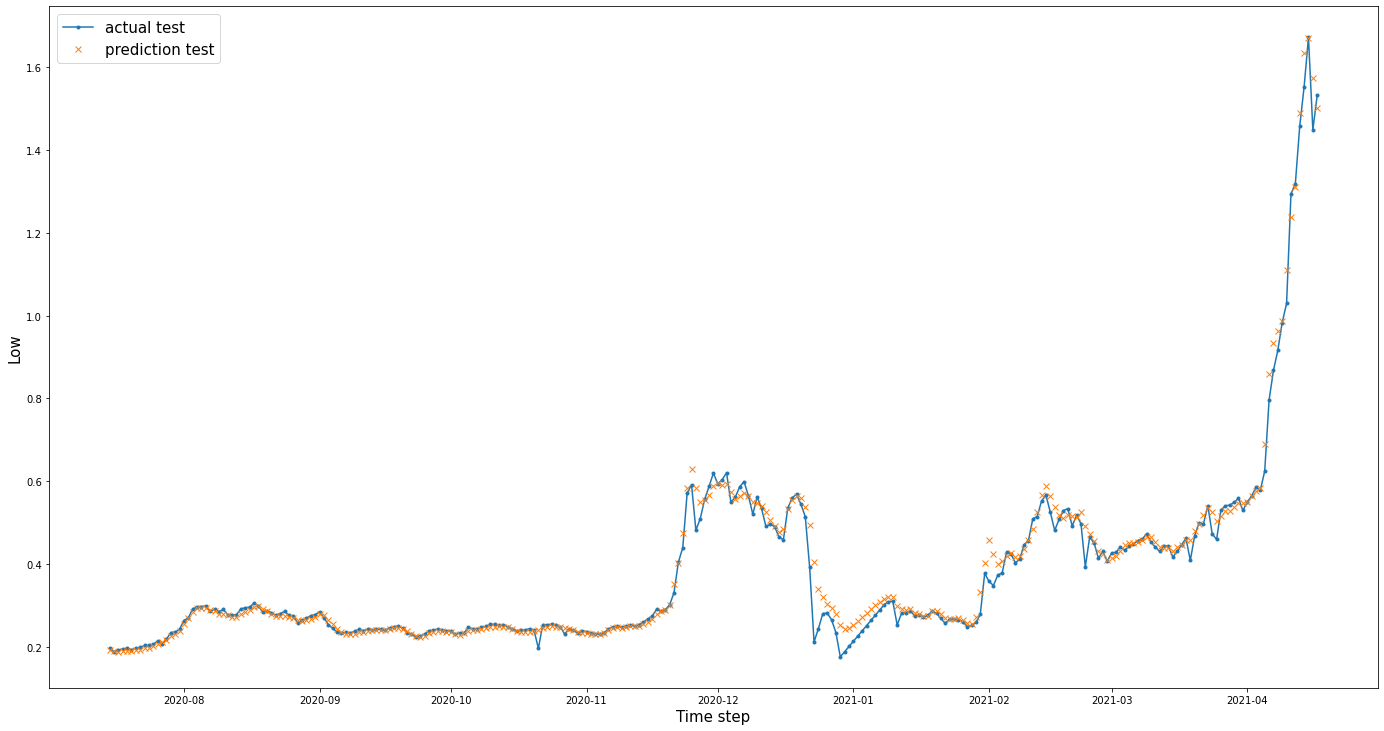

In [76]:
dates = list(ohlcv.index.values)
plt.figure(figsize=(20,10))
#plt.plot(dates[:len(y)], y, marker='.', label="actual train")
#plt.plot(dates[:len(train_predict)], train_predict, 'r', label="prediction train")
plt.plot(dates[-len(y_test):], y_test, marker='.', label="actual test")
plt.plot(dates[-len(test_predict):], test_predict, 'x', label="prediction test")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Low', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();